In [1]:
!python -V

Python 3.9.12


In [2]:
import pandas as pd

In [3]:
# Assuming df is your DataFrame
pd.set_option('display.max_columns', None)

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
import pickle

In [6]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [7]:
import mlflow


mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

<Experiment: artifact_location='/workspaces/mlops-zoomcamp/02-experiment-tracking/mlruns/1', creation_time=1716701455928, experiment_id='1', last_update_time=1716701455928, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [8]:
url1 = 'https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2023-01.parquet'

In [9]:
url2 = 'https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2023-02.parquet'

In [10]:
df = pd.read_parquet(url1)

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds()/60)

df = df[(df.duration>=1) & (df.duration<=60)]

categorical =['PULocationID','DOLocationID']
numerical =['trip_distance']

df[categorical] = df[categorical].astype(str)

#### Dictionary Vectorizer takes dictionary as input

In [11]:
# Convert datafromae into dictionary, i.e each row of dataframe is converted into a dictionary.
train_dicts = df[categorical + numerical].to_dict(orient = 'records')


dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)


target = 'duration'
Y_train = df[target].values


# Linear Regression
lr = LinearRegression()
lr.fit(X_train, Y_train)


Y_preds = lr.predict(X_train)

mean_squared_error(Y_train, Y_preds)

49.562498271367254

/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


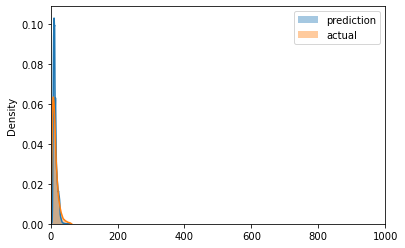

In [12]:
sns.distplot(Y_preds, label= 'prediction')
sns.distplot(Y_train, label = 'actual')

# Set x-axis limit to focus on the concentrated region
plt.xlim(0, 1000)  # Adjust the limits according to your data

plt.legend()

In [13]:
def read_dataframe(url):
    df = pd.read_parquet(url1)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds()/60)

    df = df[(df.duration>=1) & (df.duration<=60)]

    categorical =['PULocationID','DOLocationID']
    numerical =['trip_distance']

    df[categorical] = df[categorical].astype(str)

    return df

In [14]:
df_train = read_dataframe(url1)
df_val = read_dataframe(url2)

In [15]:
len(df_train), len(df_val)

(65946, 65946)

In [16]:
df_train['PU_DO'] = df_train['PULocationID'] +'_'+ df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] +'_'+ df_val['DOLocationID']

In [17]:
categorical = ['PU_DO'] #['PULocationID','DOLocationID']
numerical =['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient = 'records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient = 'records')
X_val = dv.fit_transform(val_dicts)

In [18]:
target = 'duration'
Y_train = df_train[target].values
Y_val = df_val[target].values

In [33]:
# Linear Regression
with mlflow.start_run():
    
    mlflow.set_tag("data-scientist","rahul","linear-regression")
    
    
    mlflow.log_param("train-data-path","https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2023-01.parquet")
    mlflow.log_param("val-data-path","https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2023-02.parquet")
    
    #mlflow.log_params("alpha",alpha)
    lr = LinearRegression()
    lr.fit(X_train, Y_train)

    Y_preds = lr.predict(X_val)

    rmse = mean_squared_error(Y_val, Y_preds, squared=False)
    mlflow.log_metric("rmse", rmse)
    
    mlflow.log_artifact(local_path='models/lin_reg.bin', artifact_path="models_pickle")
    print(rmse)

4.754276878808011


In [29]:
%pwd

'/workspaces/mlops-zoomcamp/02-experiment-tracking'

In [32]:
with open('models/lin_reg.bin','wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [20]:
# Lasso Regression
with mlflow.start_run():
    
    mlflow.set_tag("data-scientist","rahul","Lasso-Regression")
    
    mlflow.log_param("train-data-path","https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2023-01.parquet")
    mlflow.log_param("val-data-path","https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2023-02.parquet")
    
    alpha = 0.0001
    mlflow.log_param("alpha", alpha)
    lr = Lasso(alpha)
    lr.fit(X_train, Y_train)

    Y_preds = lr.predict(X_val)
    rmse = mean_squared_error(Y_val, Y_preds, squared=False)
    mlflow.log_metric("rmse", rmse)
    print(rmse)

4.937788083312245


In [21]:
# Ridge Regression
with mlflow.start_run():
    
    mlflow.set_tag("data-scientist","rahul","Ridge-Regression")
    
    
    mlflow.log_param("train-data-path","https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2023-01.parquet")
    mlflow.log_param("val-data-path","https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2023-02.parquet")
    
    
    lr = Ridge()
    lr.fit(X_train, Y_train)

    Y_preds = lr.predict(X_val)
    rmse = mean_squared_error(Y_val, Y_preds, squared=False)
    mlflow.log_metric("rmse", rmse)
    print(rmse)

5.704636733905528


In [ ]:
%pwd

In [ ]:
with open('models/lin_reg.bin','wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [23]:
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [24]:
train = xgb.DMatrix(X_train, label=Y_train)
val = xgb.DMatrix(X_val, label=Y_val)

In [30]:
def objective(params):
    
    with mlflow.start_run():
        mlflow.set_tag("model","xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(val, "validation")],
            early_stopping_rounds=50
        )
        Y_preds = booster.predict(val)
        rmse = mean_squared_error(Y_val, Y_preds, squared=False)
        mlflow.log_metric("rmse",rmse)
    
    return {'loss': rmse, 'status': STATUS_OK}

In [31]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42,
}

best_result = fmin(
fn=objective,
space=search_space,
algo=tpe.suggest,
max_evals=50,
trials=Trials())

  0%|                                     | 0/50 [00:00<?, ?trial/s, best loss=?]

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:59:09] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:5.60881                                                      
[1]	validation-rmse:5.27962                                                      
[2]	validation-rmse:5.18152                                                      
[3]	validation-rmse:5.11977                                                      
[4]	validation-rmse:5.09695                                                      
[5]	validation-rmse:5.08864                                                      
[6]	validation-rmse:5.07619                                                      
[7]	validation-rmse:5.07144                                                      
[8]	validation-rmse:5.05376                                                      
[9]	validation-rmse:5.04719                                                      
[10]	validation-rmse:5.03906                                                     
[11]	validation-rmse:5.03410                                                     
[12]	validation-

[198]	validation-rmse:4.69316                                                    
[199]	validation-rmse:4.69229                                                    
[200]	validation-rmse:4.69120                                                    
[201]	validation-rmse:4.69037                                                    
[202]	validation-rmse:4.68958                                                    
[203]	validation-rmse:4.68881                                                    
[204]	validation-rmse:4.68825                                                    
[205]	validation-rmse:4.68732                                                    
[206]	validation-rmse:4.68673                                                    
[207]	validation-rmse:4.68592                                                    
[208]	validation-rmse:4.68546                                                    
[209]	validation-rmse:4.68486                                                    
[210]	validation

[396]	validation-rmse:4.59716                                                    
[397]	validation-rmse:4.59692                                                    
[398]	validation-rmse:4.59661                                                    
[399]	validation-rmse:4.59628                                                    
[400]	validation-rmse:4.59607                                                    
[401]	validation-rmse:4.59572                                                    
[402]	validation-rmse:4.59535                                                    
[403]	validation-rmse:4.59510                                                    
[404]	validation-rmse:4.59472                                                    
[405]	validation-rmse:4.59437                                                    
[406]	validation-rmse:4.59407                                                    
[407]	validation-rmse:4.59386                                                    
[408]	validation

[594]	validation-rmse:4.54771                                                    
[595]	validation-rmse:4.54753                                                    
[596]	validation-rmse:4.54738                                                    
[597]	validation-rmse:4.54712                                                    
[598]	validation-rmse:4.54692                                                    
[599]	validation-rmse:4.54676                                                    
[600]	validation-rmse:4.54658                                                    
[601]	validation-rmse:4.54642                                                    
[602]	validation-rmse:4.54617                                                    
[603]	validation-rmse:4.54605                                                    
[604]	validation-rmse:4.54581                                                    
[605]	validation-rmse:4.54554                                                    
[606]	validation

[792]	validation-rmse:4.51778                                                    
[793]	validation-rmse:4.51768                                                    
[794]	validation-rmse:4.51760                                                    
[795]	validation-rmse:4.51749                                                    
[796]	validation-rmse:4.51740                                                    
[797]	validation-rmse:4.51731                                                    
[798]	validation-rmse:4.51720                                                    
[799]	validation-rmse:4.51710                                                    
[800]	validation-rmse:4.51701                                                    
[801]	validation-rmse:4.51690                                                    
[802]	validation-rmse:4.51671                                                    
[803]	validation-rmse:4.51661                                                    
[804]	validation

[990]	validation-rmse:4.49659                                                    
[991]	validation-rmse:4.49645                                                    
[992]	validation-rmse:4.49634                                                    
[993]	validation-rmse:4.49623                                                    
[994]	validation-rmse:4.49615                                                    
[995]	validation-rmse:4.49604                                                    
[996]	validation-rmse:4.49594                                                    
[997]	validation-rmse:4.49584                                                    
[998]	validation-rmse:4.49575                                                    
[999]	validation-rmse:4.49565                                                    
  2%|▏        | 1/50 [03:51<3:09:26, 231.97s/trial, best loss: 4.495652482923471]

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [16:03:01] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.99234                                                      
[1]	validation-rmse:7.20956                                                      
[2]	validation-rmse:6.62661                                                      
[3]	validation-rmse:6.19811                                                      
[4]	validation-rmse:5.88734                                                      
[5]	validation-rmse:5.66246                                                      
[6]	validation-rmse:5.50299                                                      
[7]	validation-rmse:5.38504                                                      
[8]	validation-rmse:5.30159                                                      
[9]	validation-rmse:5.23117                                                      
[10]	validation-rmse:5.17965                                                     
[11]	validation-rmse:5.14233                                                     
[12]	validation-

[198]	validation-rmse:4.70539                                                    
[199]	validation-rmse:4.70465                                                    
[200]	validation-rmse:4.70409                                                    
[201]	validation-rmse:4.70350                                                    
[202]	validation-rmse:4.70270                                                    
[203]	validation-rmse:4.70230                                                    
[204]	validation-rmse:4.70162                                                    
[205]	validation-rmse:4.70094                                                    
[206]	validation-rmse:4.70030                                                    
[207]	validation-rmse:4.69992                                                    
[208]	validation-rmse:4.69932                                                    
[209]	validation-rmse:4.69900                                                    
[210]	validation

[396]	validation-rmse:4.60062                                                    
[397]	validation-rmse:4.60038                                                    
[398]	validation-rmse:4.59992                                                    
[399]	validation-rmse:4.59964                                                    
[400]	validation-rmse:4.59939                                                    
[401]	validation-rmse:4.59889                                                    
[402]	validation-rmse:4.59847                                                    
[403]	validation-rmse:4.59830                                                    
[404]	validation-rmse:4.59773                                                    
[405]	validation-rmse:4.59746                                                    
[406]	validation-rmse:4.59723                                                    
[407]	validation-rmse:4.59697                                                    
[408]	validation

[594]	validation-rmse:4.53084                                                    
[595]	validation-rmse:4.53048                                                    
[596]	validation-rmse:4.52997                                                    
[597]	validation-rmse:4.52976                                                    
[598]	validation-rmse:4.52930                                                    
[599]	validation-rmse:4.52919                                                    
[600]	validation-rmse:4.52871                                                    
[601]	validation-rmse:4.52846                                                    
[602]	validation-rmse:4.52817                                                    
[603]	validation-rmse:4.52801                                                    
[604]	validation-rmse:4.52778                                                    
[605]	validation-rmse:4.52760                                                    
[606]	validation

[792]	validation-rmse:4.47893                                                    
[793]	validation-rmse:4.47850                                                    
[794]	validation-rmse:4.47833                                                    
[795]	validation-rmse:4.47788                                                    
[796]	validation-rmse:4.47753                                                    
[797]	validation-rmse:4.47739                                                    
[798]	validation-rmse:4.47719                                                    
[799]	validation-rmse:4.47706                                                    
[800]	validation-rmse:4.47677                                                    
[801]	validation-rmse:4.47655                                                    
[802]	validation-rmse:4.47634                                                    
[803]	validation-rmse:4.47606                                                    
[804]	validation

KeyboardInterrupt: 

In [25]:
params = {
    'learning_rate': 0.20472169880371677,
    'max_depth': 17,
    'min_child_weight': 1.2402611720043835,
    'objective': 'reg:linear',
    'reg_alpha': 0.28567896734700793,
    'reg_lambda': 0.004264404814393109,
    'seed': 42
}

mlflow.xgboost.autolog()

booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(val, "validation")],
            early_stopping_rounds=50
        )

2024/05/29 13:59:43 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '281cbd1b8c8c46a9b8106b10503539cd', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow
/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:59:46] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:7.84008
[1]	validation-rmse:6.98394
[2]	validation-rmse:6.37325
[3]	validation-rmse:5.94679
[4]	validation-rmse:5.64276
[5]	validation-rmse:5.43193
[6]	validation-rmse:5.28742
[7]	validation-rmse:5.18349
[8]	validation-rmse:5.10641
[9]	validation-rmse:5.04981
[10]	validation-rmse:5.00395
[11]	validation-rmse:4.97010
[12]	validation-rmse:4.94300
[13]	validation-rmse:4.92119
[14]	validation-rmse:4.90369
[15]	validation-rmse:4.88803
[16]	validation-rmse:4.87434
[17]	validation-rmse:4.86158
[18]	validation-rmse:4.85161
[19]	validation-rmse:4.84367
[20]	validation-rmse:4.83763
[21]	validation-rmse:4.83257
[22]	validation-rmse:4.82427
[23]	validation-rmse:4.81901
[24]	validation-rmse:4.81493
[25]	validation-rmse:4.80963
[26]	validation-rmse:4.80588
[27]	validation-rmse:4.80005
[28]	validation-rmse:4.79600
[29]	validation-rmse:4.79155
[30]	validation-rmse:4.78821
[31]	validation-rmse:4.78434
[32]	validation-rmse:4.78037
[33]	validation-rmse:4.77728
[34]	validation-rmse:4.7

[277]	validation-rmse:4.34139
[278]	validation-rmse:4.34010
[279]	validation-rmse:4.33931
[280]	validation-rmse:4.33797
[281]	validation-rmse:4.33730
[282]	validation-rmse:4.33672
[283]	validation-rmse:4.33591
[284]	validation-rmse:4.33350
[285]	validation-rmse:4.33266
[286]	validation-rmse:4.33198
[287]	validation-rmse:4.32894
[288]	validation-rmse:4.32825
[289]	validation-rmse:4.32739
[290]	validation-rmse:4.32690
[291]	validation-rmse:4.32622
[292]	validation-rmse:4.32537
[293]	validation-rmse:4.32473
[294]	validation-rmse:4.32405
[295]	validation-rmse:4.32146
[296]	validation-rmse:4.32098
[297]	validation-rmse:4.32021
[298]	validation-rmse:4.31950
[299]	validation-rmse:4.31877
[300]	validation-rmse:4.31775
[301]	validation-rmse:4.31697
[302]	validation-rmse:4.31636
[303]	validation-rmse:4.31567
[304]	validation-rmse:4.31499
[305]	validation-rmse:4.31427
[306]	validation-rmse:4.31301
[307]	validation-rmse:4.31251
[308]	validation-rmse:4.31200
[309]	validation-rmse:4.31116
[310]	vali

[551]	validation-rmse:4.12016
[552]	validation-rmse:4.11990
[553]	validation-rmse:4.11795
[554]	validation-rmse:4.11668
[555]	validation-rmse:4.11644
[556]	validation-rmse:4.11581
[557]	validation-rmse:4.11556
[558]	validation-rmse:4.11523
[559]	validation-rmse:4.11473
[560]	validation-rmse:4.11445
[561]	validation-rmse:4.11423
[562]	validation-rmse:4.11400
[563]	validation-rmse:4.11212
[564]	validation-rmse:4.11185
[565]	validation-rmse:4.11167
[566]	validation-rmse:4.11104
[567]	validation-rmse:4.11081
[568]	validation-rmse:4.11057
[569]	validation-rmse:4.11026
[570]	validation-rmse:4.10952
[571]	validation-rmse:4.10914
[572]	validation-rmse:4.10897
[573]	validation-rmse:4.10863
[574]	validation-rmse:4.10774
[575]	validation-rmse:4.10663
[576]	validation-rmse:4.10420
[577]	validation-rmse:4.10374
[578]	validation-rmse:4.10319
[579]	validation-rmse:4.10274
[580]	validation-rmse:4.10255
[581]	validation-rmse:4.10235
[582]	validation-rmse:4.10138
[583]	validation-rmse:4.10113
[584]	vali

[825]	validation-rmse:3.98828
[826]	validation-rmse:3.98810
[827]	validation-rmse:3.98799
[828]	validation-rmse:3.98753
[829]	validation-rmse:3.98728
[830]	validation-rmse:3.98716
[831]	validation-rmse:3.98704
[832]	validation-rmse:3.98659
[833]	validation-rmse:3.98607
[834]	validation-rmse:3.98586
[835]	validation-rmse:3.98554
[836]	validation-rmse:3.98545
[837]	validation-rmse:3.98529
[838]	validation-rmse:3.98483
[839]	validation-rmse:3.98469
[840]	validation-rmse:3.98421
[841]	validation-rmse:3.98362
[842]	validation-rmse:3.98351
[843]	validation-rmse:3.98322
[844]	validation-rmse:3.98307
[845]	validation-rmse:3.98291
[846]	validation-rmse:3.98271
[847]	validation-rmse:3.98152
[848]	validation-rmse:3.98115
[849]	validation-rmse:3.98086
[850]	validation-rmse:3.98068
[851]	validation-rmse:3.98035
[852]	validation-rmse:3.98010
[853]	validation-rmse:3.97975
[854]	validation-rmse:3.97959
[855]	validation-rmse:3.97946
[856]	validation-rmse:3.97908
[857]	validation-rmse:3.97888
[858]	vali

2024/05/29 14:01:01 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [14:01:01] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."
2024/05/29 14:01:07 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/codespace/anaconda3/lib/python3.9/site-packages/_distutils_hack/__init__.py:30: UserWarning: Setuptools is replacing distutils."


In [35]:
mlflow.xgboost.autolog(disable=True)

In [36]:
with mlflow.start_run():
    
    train = xgb.DMatrix(X_train, label=Y_train)
    val = xgb.DMatrix(X_val, label=Y_val)
    
    best_params = {
    'learning_rate': 0.20472169880371677,
    'max_depth': 17,
    'min_child_weight': 1.2402611720043835,
    'objective': 'reg:linear',
    'reg_alpha': 0.28567896734700793,
    'reg_lambda': 0.004264404814393109,
    'seed': 42
    }
    
    mlflow.log_params(best_params)

    booster = xgb.train(
                params=best_params,
                dtrain=train,
                num_boost_round=1000,
                evals=[(val, "validation")],
                early_stopping_rounds=50
            )
    
    Y_preds = booster.predict(val)
    rmse = mean_squared_error(Y_val, Y_preds, squared=False)
    mlflow.log_metric("rmse", rmse)
    
    with open("models/preprocessor.b", "wb") as f_out:
        pickle.dump(dv, f_out)
    
    mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")
    
    mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:08:00] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:7.84008
[1]	validation-rmse:6.98394
[2]	validation-rmse:6.37325
[3]	validation-rmse:5.94679
[4]	validation-rmse:5.64276
[5]	validation-rmse:5.43193
[6]	validation-rmse:5.28742
[7]	validation-rmse:5.18349
[8]	validation-rmse:5.10641
[9]	validation-rmse:5.04981
[10]	validation-rmse:5.00395
[11]	validation-rmse:4.97010
[12]	validation-rmse:4.94300
[13]	validation-rmse:4.92119
[14]	validation-rmse:4.90369
[15]	validation-rmse:4.88803
[16]	validation-rmse:4.87434
[17]	validation-rmse:4.86158
[18]	validation-rmse:4.85161
[19]	validation-rmse:4.84367
[20]	validation-rmse:4.83763
[21]	validation-rmse:4.83257
[22]	validation-rmse:4.82427
[23]	validation-rmse:4.81901
[24]	validation-rmse:4.81493
[25]	validation-rmse:4.80963
[26]	validation-rmse:4.80588
[27]	validation-rmse:4.80005
[28]	validation-rmse:4.79600
[29]	validation-rmse:4.79155
[30]	validation-rmse:4.78821
[31]	validation-rmse:4.78434
[32]	validation-rmse:4.78037
[33]	validation-rmse:4.77728
[34]	validation-rmse:4.7

[277]	validation-rmse:4.34139
[278]	validation-rmse:4.34010
[279]	validation-rmse:4.33931
[280]	validation-rmse:4.33797
[281]	validation-rmse:4.33730
[282]	validation-rmse:4.33672
[283]	validation-rmse:4.33591
[284]	validation-rmse:4.33350
[285]	validation-rmse:4.33266
[286]	validation-rmse:4.33198
[287]	validation-rmse:4.32894
[288]	validation-rmse:4.32825
[289]	validation-rmse:4.32739
[290]	validation-rmse:4.32690
[291]	validation-rmse:4.32622
[292]	validation-rmse:4.32537
[293]	validation-rmse:4.32473
[294]	validation-rmse:4.32405
[295]	validation-rmse:4.32146
[296]	validation-rmse:4.32098
[297]	validation-rmse:4.32021
[298]	validation-rmse:4.31950
[299]	validation-rmse:4.31877
[300]	validation-rmse:4.31775
[301]	validation-rmse:4.31697
[302]	validation-rmse:4.31636
[303]	validation-rmse:4.31567
[304]	validation-rmse:4.31499
[305]	validation-rmse:4.31427
[306]	validation-rmse:4.31301
[307]	validation-rmse:4.31251
[308]	validation-rmse:4.31200
[309]	validation-rmse:4.31116
[310]	vali

[551]	validation-rmse:4.12016
[552]	validation-rmse:4.11990
[553]	validation-rmse:4.11795
[554]	validation-rmse:4.11668
[555]	validation-rmse:4.11644
[556]	validation-rmse:4.11581
[557]	validation-rmse:4.11556
[558]	validation-rmse:4.11523
[559]	validation-rmse:4.11473
[560]	validation-rmse:4.11445
[561]	validation-rmse:4.11423
[562]	validation-rmse:4.11400
[563]	validation-rmse:4.11212
[564]	validation-rmse:4.11185
[565]	validation-rmse:4.11167
[566]	validation-rmse:4.11104
[567]	validation-rmse:4.11081
[568]	validation-rmse:4.11057
[569]	validation-rmse:4.11026
[570]	validation-rmse:4.10952
[571]	validation-rmse:4.10914
[572]	validation-rmse:4.10897
[573]	validation-rmse:4.10863
[574]	validation-rmse:4.10774
[575]	validation-rmse:4.10663
[576]	validation-rmse:4.10420
[577]	validation-rmse:4.10374
[578]	validation-rmse:4.10319
[579]	validation-rmse:4.10274
[580]	validation-rmse:4.10255
[581]	validation-rmse:4.10235
[582]	validation-rmse:4.10138
[583]	validation-rmse:4.10113
[584]	vali

[825]	validation-rmse:3.98828
[826]	validation-rmse:3.98810
[827]	validation-rmse:3.98799
[828]	validation-rmse:3.98753
[829]	validation-rmse:3.98728
[830]	validation-rmse:3.98716
[831]	validation-rmse:3.98704
[832]	validation-rmse:3.98659
[833]	validation-rmse:3.98607
[834]	validation-rmse:3.98586
[835]	validation-rmse:3.98554
[836]	validation-rmse:3.98545
[837]	validation-rmse:3.98529
[838]	validation-rmse:3.98483
[839]	validation-rmse:3.98469
[840]	validation-rmse:3.98421
[841]	validation-rmse:3.98362
[842]	validation-rmse:3.98351
[843]	validation-rmse:3.98322
[844]	validation-rmse:3.98307
[845]	validation-rmse:3.98291
[846]	validation-rmse:3.98271
[847]	validation-rmse:3.98152
[848]	validation-rmse:3.98115
[849]	validation-rmse:3.98086
[850]	validation-rmse:3.98068
[851]	validation-rmse:3.98035
[852]	validation-rmse:3.98010
[853]	validation-rmse:3.97975
[854]	validation-rmse:3.97959
[855]	validation-rmse:3.97946
[856]	validation-rmse:3.97908
[857]	validation-rmse:3.97888
[858]	vali

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:09:04] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


In [38]:
logged_model = 'runs:/a7036b32313a45f9a6c10da61b93cd16/models_mlflow'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:13:39] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


In [39]:
loaded_model

mlflow.pyfunc.loaded_model:
  artifact_path: models_mlflow
  flavor: mlflow.xgboost
  run_id: a7036b32313a45f9a6c10da61b93cd16

In [40]:
xgboost_model = mlflow.xgboost.load_model(logged_model)

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:14:52] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


In [41]:
xgboost_model

In [42]:
Y_preds = xgboost_model.predict(val)

In [43]:
Y_preds[:10]

array([14.867404 , 10.060206 , 11.867634 ,  7.2934113,  7.588369 ,
       16.034542 , 20.022093 , 11.820657 ,  7.0727577, 23.261528 ],
      dtype=float32)